# VQA

In [15]:
import torch
import numpy as np
import re
from fairseq import utils,tasks
from fairseq import checkpoint_utils
from fairseq import distributed_utils, options, tasks, utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
from OFA.utils.zero_shot_utils import zero_shot_step
from tasks.mm_tasks.vqa_gen import VqaGenTask
from models.ofa import OFAModel
from PIL import Image, ImageDraw
from skimage.measure import find_contours, label, regionprops
import cv2
import matplotlib.pyplot as plt

# Register VQA task
tasks.register_task('vqa_gen',VqaGenTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = True

# specify some options for evaluation
parser = options.get_generation_parser()
input_args = ["", "--task=vqa_gen", "--beam=100", "--unnormalized", "--path=checkpoints/ofa_large_384.pt", "--bpe-dir=utils/BPE"]
args = options.parse_args_and_arch(parser, input_args)
cfg = convert_namespace_to_omegaconf(args)

In [16]:
%%timeit

cfg = convert_namespace_to_omegaconf(args)

# Load pretrained ckpt & config
task = tasks.setup_task(cfg.task)
models, cfg = checkpoint_utils.load_model_ensemble(
    utils.split_paths(cfg.common_eval.path),
    task=task
)

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

2023-05-12 12:02:43 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-05-12 12:02:43 | INFO | tasks.ofa_task | target dictionary: 59457 types
2023-05-12 12:02:54 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-05-12 12:02:54 | INFO | tasks.ofa_task | target dictionary: 59457 types
2023-05-12 12:03:04 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-05-12 12:03:04 | INFO | tasks.ofa_task | target dictionary: 59457 types
2023-05-12 12:03:15 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-05-12 12:03:15 | INFO | tasks.ofa_task | target dictionary: 59457 types
2023-05-12 12:03:25 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-05-12 12:03:25 | INFO | tasks.ofa_task | target dictionary: 59457 types
2023-05-12 12:03:36 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-05-12 12:03:36 | INFO | tasks.ofa_task | target dictionary: 59457 types
2023-05-12 12:03:46 | INFO | tasks.ofa_task | source dictionary: 59457 types

10.3 s ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()

# Normalize the question
def pre_question(question, max_ques_words):
    question = question.lower().lstrip(",.!?*#:;~").replace('-', ' ').replace('/', ' ')
    question = re.sub(
        r"\s{2,}",
        ' ',
        question,
    )
    question = question.rstrip('\n')
    question = question.strip(' ')
    # truncate question
    question_words = question.split(' ')
    if len(question_words) > max_ques_words:
        question = ' '.join(question_words[:max_ques_words])
    return question

def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for open-domain VQA task
def construct_sample(image: Image, question: str):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])

    question = pre_question(question, task.cfg.max_src_length)
    question = question + '?' if not question.endswith('?') else question
    src_text = encode_text(' {}'.format(question), append_bos=True, append_eos=True).unsqueeze(0)

    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    ref_dict = np.array([{'yes': 1.0}]) # just placeholder
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        },
        "ref_dict": ref_dict,
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

In [12]:
""" Convert a mask to border image """


def mask_to_border(mask):

    h, w = mask.shape
    border = np.zeros((h, w))

    contours = find_contours(mask, 128)
    for contour in contours:
        for c in contour:
            x = int(c[0])
            y = int(c[1])
            border[x][y] = 255

    return border


""" Mask to bounding boxes """


def mask_to_bbox(mask):
    bboxes = []

    mask = mask_to_border(mask)
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        x1 = prop.bbox[1]
        y1 = prop.bbox[0]

        x2 = prop.bbox[3]
        y2 = prop.bbox[2]

        bboxes.append([x1, y1, x2, y2])

    return bboxes


""" Mask to bounding features """


def mask_to_overall_bbox(mask_path):
    """_summary_
    function to get auxiliary information of image
    Args:
        mask_path (string): mask image's path

    Returns:
        list: a list of overall bbox coordinates

    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    bboxes = mask_to_bbox(mask)
    # num_polyps = 0 if len(bboxes) == 1 else 1
    # polyp_sizes = None
    min_x1 = mask.shape[1]
    min_y1 = mask.shape[0]
    max_x2 = 0
    max_y2 = 0
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        area = (x2 - x1) * (y2 - y1)
        if float(area) > 4:
            if x1 < min_x1:
                min_x1 = x1
            if y1 < min_y1:
                min_y1 = y1
            if x2 > max_x2:
                max_x2 = x2
            if y2 > max_y2:
                max_y2 = y2
    return [min_x1, min_y1, max_x2, max_y2]

In [13]:
def get_answer(image_path, mask_path, question):
    image = Image.open(image_path)
    h, w, c = np.array(image).shape
    image_draw = ImageDraw.Draw(image)
    bbox_coords = mask_to_overall_bbox(mask_path)
    image_draw.rectangle([max(0, bbox_coords[0] - 10), max(0, bbox_coords[1] - 10), min(w, bbox_coords[2] + 10), min(h, bbox_coords[3] + 10)], width=5, outline='#00ff00')
    
    sample = construct_sample(image, question)
    sample = utils.move_to_cuda(sample) if use_cuda else sample
    sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
    
    # Run eval step for open-domain VQA
    with torch.no_grad():
        result, scores = zero_shot_step(task, generator, models, sample)
        
    display(image)
    print('Question: {}'.format(question))
    print('OFA\'s Answer: {}'.format(result[0]['answer']))

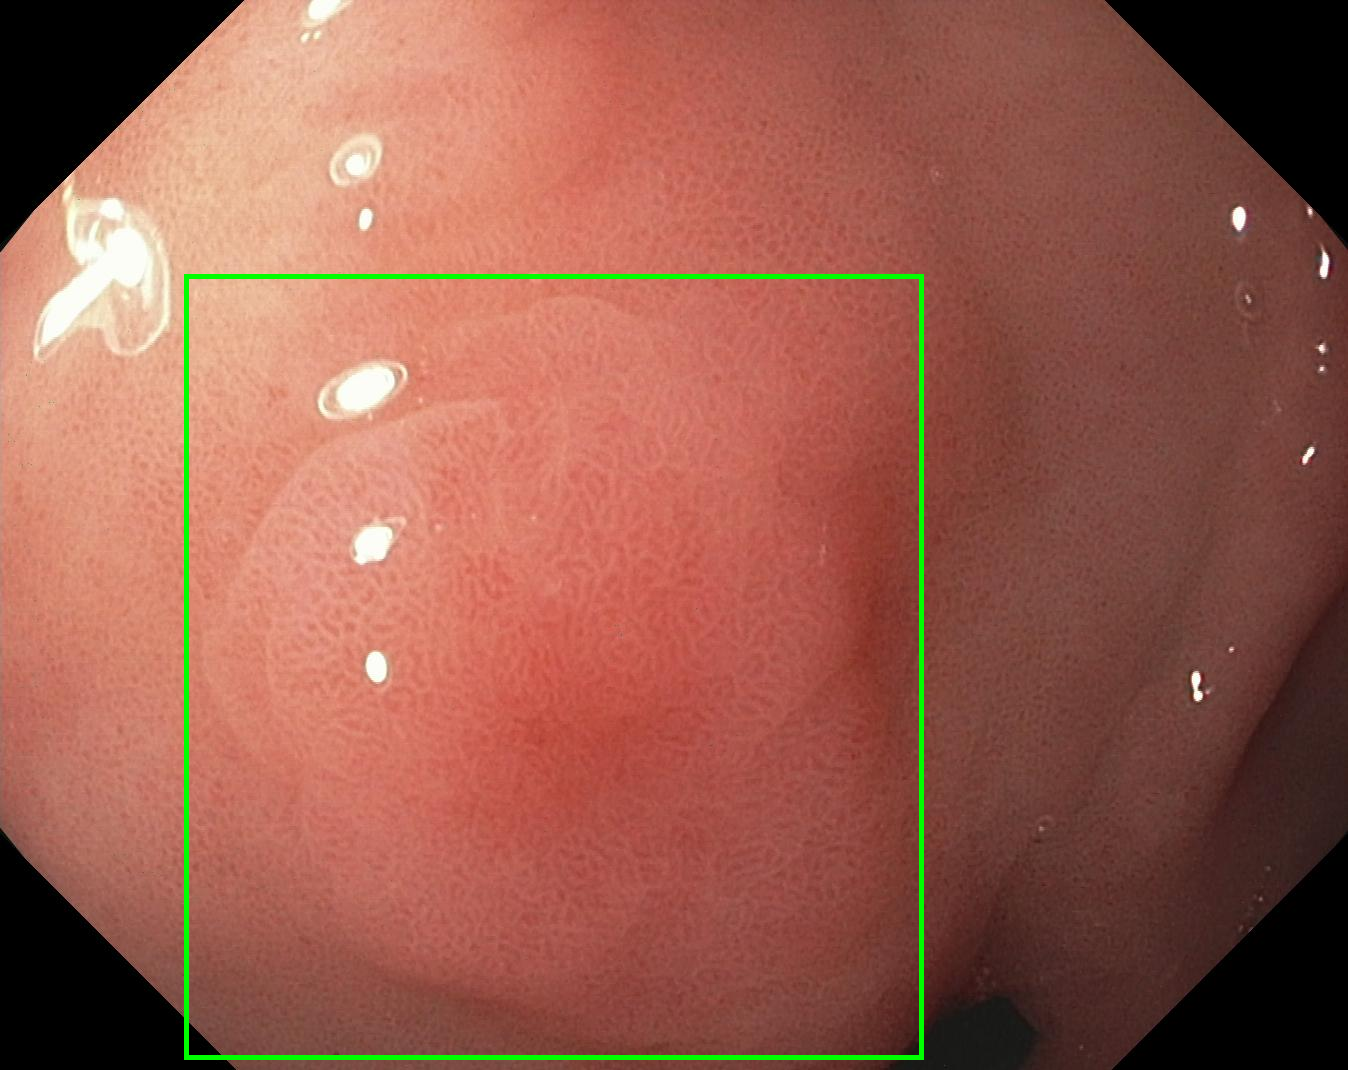

Question: What is the color of bump enclosed in green box?
OFA's Answer: white


In [15]:
# %%timeit
image_number = 1
image_path = f'/mnt/Enterprise/PUBLIC_DATASETS/polyp_datasets/Kvasir-SEG/images_cf/{image_number}.jpg'
mask_path = f'/mnt/Enterprise/PUBLIC_DATASETS/polyp_datasets/Kvasir-SEG/masks_cf/{image_number}.png'
question1 = 'What is the shape of bump enclosed in green box?'
question2 = 'What is the color of bump enclosed in green box?'
question3 = 'What is the size of bump enclosed in green box?'
question4 = 'What is the texture of bump enclosed in green box?'
question5 = 'What is the location of bump enclosed in green box?'
question6 = 'What is the color of the box?'
get_answer(image_path, mask_path, question2)